# Building a Basic Topic Model from the (Generated) ATS Document Database

Here I explore the ATS document database --- which should have already been scraped, cleaned, and compiled by scripts held in `/src/`, and managed via `make scrape` and `make data` --- and then train a basic topic model on the corpus. I explore the resulting topics briefly, and show changes by year of meeting.

## Requirements

Let's start by meeting some basic requirements:

In [1]:
!pip install pandas
!pip install numpy
!pip install wordcloud
!pip install gensim==3.8.3
!pip install seaborn
!pip install matplotlib

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the

We'll also be using `mallet` (via the `gensim` wrapper), so we need to make sure that's installed for use:

In [2]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-07-09 13:22:31--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: 'mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  92.8KB/s    in 3m 5s   

2021-07-09 13:25:37 (85.3 KB/s) - 'mallet-2.0.8.zip.2’ saved [16184794/16184794]



In [3]:
!unzip -o mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostM2.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostM2Trainer.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostTrainer.class  
  in

  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFOptimizableByLabelLikelihood.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFTrainerByL1LabelLikelihood.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFTrainerByLabelLikelihood.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFTrainerByStochasticGradient.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFTrainerByThreadedLabelLikelihood.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFTrainerByValueGradients$OptimizableCRF.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFTrainerByValueGradients.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/CRFWriter.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/FeatureTransducer$State.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/FeatureTransducer$Transition.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/FeatureTransducer$TransitionIterator.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/FeatureTransducer.class  
  inflat

  inflating: mallet-2.0.8/class/cc/mallet/pipe/tests/TestSGML2TokenSequence$Array2ArrayIterator.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/tests/TestSGML2TokenSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/tests/TestSpacePipe.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/Token2FeatureVector.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/TokenSequence2FeatureSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/TokenSequence2FeatureSequenceWithBigrams.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/TokenSequence2FeatureVectorSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/TokenSequence2TokenInstances$TokenInstanceIterator.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/TokenSequence2TokenInstances.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/TokenSequenceLowercase.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/TokenSequenceMatchDataAndTarget.class  
  inflating: mallet-2.0.8/class/cc/

  inflating: mallet-2.0.8/dist/mallet-deps.jar  
  inflating: mallet-2.0.8/dist/mallet.jar  
  inflating: mallet-2.0.8/lib/bsh.jar  
  inflating: mallet-2.0.8/lib/derby.jar  
  inflating: mallet-2.0.8/lib/grmm-deps.jar  
  inflating: mallet-2.0.8/lib/jdom-1.0.jar  
  inflating: mallet-2.0.8/lib/jgrapht-0.6.0.jar  
  inflating: mallet-2.0.8/lib/junit-4.5.jar  
  inflating: mallet-2.0.8/lib/jwnl-1.3.jar  
  inflating: mallet-2.0.8/lib/LICENSES  
  inflating: mallet-2.0.8/lib/Makefile  
  inflating: mallet-2.0.8/lib/mallet-deps.jar  
  inflating: mallet-2.0.8/lib/mtj-0.9.9.jar  
  inflating: mallet-2.0.8/lib/openjgraph.jar  
  inflating: mallet-2.0.8/lib/trove-2.0.2.jar  
  inflating: mallet-2.0.8/LICENSE    
  inflating: mallet-2.0.8/Makefile   
  inflating: mallet-2.0.8/pom.xml    
  inflating: mallet-2.0.8/README.md  
  inflating: mallet-2.0.8/sample-data/numeric/boxes.txt  
  inflating: mallet-2.0.8/sample-data/numeric/puffins.txt  
  inflating: mallet-2.0.8/sample-data/README  
  inf

  inflating: mallet-2.0.8/src/cc/mallet/classify/tui/Vectors2Vectors.java  
  inflating: mallet-2.0.8/src/cc/mallet/classify/Winnow.java  
  inflating: mallet-2.0.8/src/cc/mallet/classify/WinnowTrainer.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/Clusterer.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/Clustering.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/clustering_scorer/ClusteringScorer.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/clustering_scorer/PairwiseScorer.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/Clusterings.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/evaluate/AccuracyEvaluator.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/evaluate/BCubedEvaluator.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/evaluate/ClusteringEvaluator.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/evaluate/ClusteringEvaluators.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/evaluate/MUCEvaluator.java  
  infla

  inflating: mallet-2.0.8/src/cc/mallet/share/weili/ner/enron/TUI.java  
  inflating: mallet-2.0.8/src/cc/mallet/share/weili/ner/WordTransformation.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/AbstractTopicReports.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/DMROptimizable.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/DMRTopicModel.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/HierarchicalLDA.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/HierarchicalPAM.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/JSONTopicReports.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/LabeledLDA.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/LDA.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/LDAHyper.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/LDAStream.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/MarginalProbEstimator.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/MultinomialHMM.java  
  inflating: mallet-2.0.8/s

In [4]:
mallet_path = './mallet-2.0.8/bin/mallet' # for use when actually passing an LDAMallet wrapper to gensim

Import the requirements for loading the data and visualising the initial exploration:

In [5]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Loading Data

In [6]:
df = pd.read_pickle('../data/processed/documents/ats_documents.pkl')

This dataframe was generated by a feature processing script (which should have been done executed via `Make`, see above). It looks like this:

In [7]:
df.head()

,filename,extension,meeting,paper_type_abbreviation,paper_number,paper_revision,paper_language_abbreviation,raw_text,meeting_year,paper_name,paper_id,paper_type_id,meeting_type,meeting_id,meeting_number,meeting_name,parties
0,ATIP2020_ip031_r.doc,doc,ATIP2020,ip,031,0,r,- About\n\n - The Antarctic Treaty\n\n ...,2020.0,Non-native species Trichocera maculipennis (Di...,11545.0,2.0,ATIP,91.0,2020,ATIP 2019/2021,Poland
1,ATCM21_ip081_e.pdf,pdf,ATCM21,ip,081,0,e,ANTARCTIC TREATY ...,1997.0,Opening address by Head of the delegation of P...,7360.0,2.0,ATCM,51.0,21,ATCM XXI,Poland
2,ATME1989_wp012_e.pdf,pdf,ATME1989,wp,012,0,e,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,1989.0,Answer to the questionnaire (Recommendation XI...,6062.0,1.0,ATME,67.0,1989,ME Air Safety,United States
3,ATCM38_bp021_r.doc,doc,ATCM38,bp,021,0,r,- About\n\n - The Antarctic Treaty\n\n ...,2015.0,Workshop on Education and Outreach – Poster Ab...,7749.0,9.0,ATCM,80.0,38,ATCM XXXVIII - CEP XVIII,Bulgaria
4,ATCM29_wp018_s.doc,doc,ATCM29,wp,018,0,s,Establecimiento de zonas de interés turístico\...,2006.0,Establishment of “areas of special tourist int...,739.0,1.0,ATCM,60.0,29,ATCM XXIX - CEP IX,France


Key info:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24711 entries, 0 to 24710
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   filename                     24711 non-null  object 
 1   extension                    24711 non-null  object 
 2   meeting                      24711 non-null  object 
 3   paper_type_abbreviation      24711 non-null  object 
 4   paper_number                 24711 non-null  object 
 5   paper_revision               24711 non-null  object 
 6   paper_language_abbreviation  24711 non-null  object 
 7   raw_text                     19083 non-null  object 
 8   meeting_year                 21865 non-null  float64
 9   paper_name                   21865 non-null  object 
 10  paper_id                     21865 non-null  float64
 11  paper_type_id                21865 non-null  float64
 12  meeting_type                 21865 non-null  object 
 13  meeting_id      

Let's confirm the number of empty text fields seen above:

In [9]:
print(f'{len(df[df.raw_text.isnull()])} of {len(df)}')

5628 of 24711


Remove these null-valued values:

In [10]:
clean_df = df[df.raw_text.notnull()]

In [11]:
print(len(clean_df))

19083


Filtered by language:

In [12]:
for language in ['e','f','s','r']:
    print(f'{language}: {len(clean_df[clean_df.paper_language_abbreviation == language])}')

e: 6028
f: 4326
s: 4491
r: 4238


We'll use the english documents for this model:

In [13]:
english_clean_df = clean_df[clean_df.paper_language_abbreviation == 'e']

## Cleaning Data

Return a lower case version:

In [14]:
import re # load the regular expression library

english_clean_df['processed_text'] = english_clean_df['raw_text'].map(lambda x: x.lower())

<ipython-input-14-38d393ae9b5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_clean_df['processed_text'] = english_clean_df['raw_text'].map(lambda x: x.lower())


## Exploring Data

We can generate an obligatory wordcloud for the whole document corpus as follows:

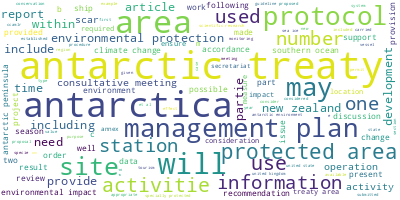

In [15]:
from wordcloud import WordCloud

# list of texts:
all_text = ','.join(list(english_clean_df['processed_text'].values))

# wordcloud object:
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steelblue')

# generate:
wordcloud.generate(all_text)

# viz:
wordcloud.to_image()

(This is, predictably, uninformative.)

We can, similarly, get a sense of the total number of papers per year:

<AxesSubplot:xlabel='meeting_year', ylabel='count'>

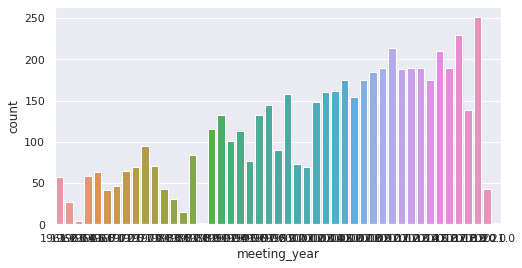

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(x='meeting_year', data=english_clean_df, orient='h')

Filtered for (only) working papers is slightly more informative here:

<AxesSubplot:xlabel='meeting_year', ylabel='count'>

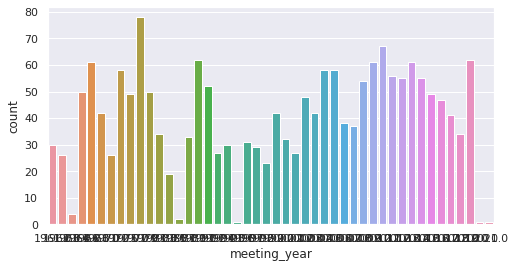

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(x='meeting_year', data=english_clean_df[english_clean_df.paper_type_abbreviation == 'wp'], orient='h')

## Preparing for the LDA Model

We start by importing the `nltk` and its stopwords:

In [ ]:
import nltk
nltk.download('stopwords')

We also need levenshtein distance for later viz:

In [ ]:
!pip install python-Levenshtein

Import the necessary pre-processing and model-building util wrappers from `gensim`:

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.wrappers import ldamallet
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

Import `spacy` for lemmatization utils:

In [ ]:
!pip install spacy

In [ ]:
import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")

## Preprocessing for LDA

Build a list of all the document texts:

In [ ]:
data = list(english_clean_df.processed_text)

Build trigram and bigram models from those texts:

In [ ]:
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Define a preprocessing function:

In [ ]:
# we only need the spacy tagger; there's no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# we load the english-language stopword corpus from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

With this defined, we can actually call the preprocessing function on our list of texts:

In [ ]:
data_ready = process_words(data)

A full dictionary for the vocab of the corpora:

In [ ]:
id2word = corpora.Dictionary(data_ready) 
print('Total Vocabulary Size:', len(id2word))

Note that this contains a large amount of repetition and noise, which we'll deal with below (via thresholds).

The corpus, implemented as a bag of words for each text in the above (preprocessed) data list:

In [ ]:
corpus = [id2word.doc2bow(text) for text in data_ready]

Now we can see the words/frequencies as a dataframe (as a sanity check:)

In [ ]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100)

In [ ]:
dict_df.sort_values('freq', ascending=False).head(10)

Filter the extremely common or extremely uncommon words (above 50% of all documents, or fewer than 10 documents):

In [ ]:
id2word.filter_extremes(no_below=10, no_above=0.5)

In [ ]:
corpus = [id2word.doc2bow(text) for text in data_ready]

We've now got a  much more believeable vocab size:

In [ ]:
print(len(id2word))


## LDA Model

Let's generate an Mallet LDA topic model for 100 topics and 500 iterations. **This takes quite a while**.

In [ ]:
n_topics = 100
n_iterations = 500

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, iterations=n_iterations, id2word=id2word)

We calculate a coherence score for the model:

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Save progress to file:

In [ ]:
import pickle
with open("../models/ldamallet.pkl", "wb") as f:
    pickle.dump(ldamallet, f)

Check topic distributions for the corpus: 

In [ ]:
tm_results = ldamallet[corpus]

The most dominant topic of each document in the corpus:

In [ ]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

The top 20 significant terms and their probabilities for each topic:

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

A term-topic matrix:

In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T

topics_df.head()

## Visualising the LDA Model

In [ ]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [ ]:
import pyLDAvis.gensim as gensimvis

vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)

pyLDAvis.display(vis_data)

### Dominant Topics for Each Document

In [ ]:
# create a dataframe
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Title'] = english_clean_df['paper_title']

corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]

corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]

corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

corpus_topic_df.head()

Now we can show the document counts for each topic and its percentage in the overall corpus:

In [ ]:
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

And also which document makes the highest contribution to each topic:

In [ ]:
corpus_topic_df.groupby(‘Dominant Topic’).apply(lambda topic_set: (topic_set.sort_values(by=[‘Contribution %’], ascending=False).iloc[0])).reset_index(drop=True)

## Topics Over Time

The topic basic weights, using the `tm_results` object defined earlier:

In [ ]:
df_weights = pd.DataFrame.from_records([{v: k for v, k in row} for row in tm_results])
df_weights.columns = ['Topic ' + str(i) for i in range(1,101)]
df_weights

We can add the year column from the original dataframe:

In [ ]:
df_weights['Year'] = english_clean_df.meeting_year

And now we can get an average of yearly topic weights:

In [ ]:
df_weights.groupby('Year').mean()

In [ ]:
df_weights['Dominant'] = df_weights.drop('Year', axis=1).idxmax(axis=1)
df_weights.head()

In [ ]:
df_dominance = df_weights.groupby('Year')['Dominant'].value_counts(normalize=True).unstack()
df_dominance

In [ ]:
df_meetings = df_weights.groupby(['meeting_type', 'Year'])['Dominant'].value_counts(normalize=True).unstack()

df_meetings.head(15)

In [ ]:
df_meetings.reset_index(inplace=True)

df_melted = df_meetings.melt(id_vars=['meeting_type', 'Year'], value_vars=['Topic ' + str(i) for i in range(1,101)], var_name='Topic', value_name='Prevalance')

df_melted

In [ ]:
# create multiindex dataframe
df_meetings.set_index(['Journal', 'Year'], inplace=True)

# set the figure size
plt.rcParams['figure.figsize'] = [10, 6]

# loop over each meeting type
for j in df_meetings.index.levels[0]:
  
  # get cross-section and plot
  df_meetings.xs(j, level=0).plot.area()
  
  plt.title(j)
  plt.legend(loc='upper left')

plt.show()